# Python - R Crosstalk (cont.)
## Jupyter Magic
Jupyter R magic can be used to make calls to R from Jupyter Notebooks and to return outputs from R functions into the Python environment.

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R -o x
x = seq(5)

In [3]:
x

array([1, 2, 3, 4, 5], dtype=int32)

## Pandas Follow-ups
Pandas can read tabulated data directly from URLs. 

In [4]:
import numpy as np
from pandas import read_csv

## Read data from URL.
url = 'https://raw.githubusercontent.com/szorowi1/qmss2017/master/module3/random/random.csv'
data = read_csv(url)
data.head(3)

,y,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10
0,tango,-5.738806,7.903669,3.322340,-0.454518,16.532828,0.108963,1.409807,-1.245656,8.429060,-9.485051
1,tango,-2.924918,4.776924,3.979680,-1.592813,10.070496,0.447814,-1.497565,0.741973,5.404957,-11.145451
2,foxtrot,-7.371013,6.783924,3.154825,-2.325751,16.109512,0.103180,0.508613,-1.168624,9.025390,-12.657244


Variables can be set as new Pandas indices using the **set_index** attribute.

In [5]:
data = data.set_index('y')

This can be especially useful for fast indexing of specific outcomes. 

In [6]:
data.loc['hotel'].head(5)

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10
y,,,,,,,,,,
hotel,-2.148849,8.209149,1.716670,-2.057981,8.346963,0.453410,-0.646912,0.990764,5.081341,-8.893599
hotel,-4.712117,12.246013,2.725242,-1.996836,9.278563,0.417651,-0.042003,-1.201154,8.530219,-10.561583
hotel,-5.610569,5.365686,2.373778,-1.945022,13.765744,0.209197,0.968587,-1.280130,9.260891,-8.820177
hotel,-5.317170,7.655662,3.141797,-1.541819,11.543820,0.374327,-1.071597,-1.939248,10.010425,-12.543524
hotel,-0.944963,7.944996,1.465616,-1.711348,14.272865,0.648101,0.930239,-1.573197,9.741746,-9.315313


## dplyr in Python: *dplython* library
To install, open the Terminal and type:
```
pip install dplython
```
For full documentation, please see [here](https://github.com/dodger487/dplython).

In [7]:
from dplython import DplyFrame, X, select, sift, head, mutate, group_by, summarize

## Convert DataFrame to DplyFrame
data_dply = DplyFrame(data.reset_index())

## Example with sift, select, and head.
data_dply >> sift( X.x01 < -5 ) >> select( X.x02, X.x03, X.x04 ) >> head(5)

,x02,x03,x04
0,7.903669,3.322340,-0.454518
2,6.783924,3.154825,-2.325751
3,11.142124,1.834319,-1.686485
4,8.635651,1.779919,-0.284258
6,7.516217,5.982479,-2.012219


In [8]:
## Example with mutate, group_by, and summarize.
(data_dply >> 
  mutate(x01_bin=X.x01.round()) >> 
  group_by(X.y, X.x01_bin) >> 
  summarize(x02_mean=X.x02.mean())) >> head(10)

,y,x01_bin,x02_mean
0,foxtrot,-11.0,8.642240
1,foxtrot,-10.0,8.888075
2,foxtrot,-9.0,9.751692
3,foxtrot,-8.0,6.948923
4,foxtrot,-7.0,7.086172
5,foxtrot,-6.0,7.231670
6,foxtrot,-5.0,8.298322
7,foxtrot,-4.0,8.113100
8,foxtrot,-3.0,8.074129
9,foxtrot,-2.0,7.237690


## dplyr in Python: *pandas-ply* library
To install, open the Terminal and type:
```
pip install pandas-ply
```
For full documentation, please see [here](https://pythonhosted.org/pandas-ply/).

In [9]:
import pandas as pd
from pandas_ply import install_ply, X, sym_call

## After calling install_ply, all pandas objects have 
## pandas-ply‘s methods attached.
install_ply(pd)

## Piping example.
(data
 .reset_index()
 .groupby('y')
 .ply_select(
    arr = X.x01.mean(),
    dep = X.x02.mean())
 .ply_where(X.arr < -5, X.dep > 7))

,arr,dep
y,,
foxtrot,-5.259068,7.888015
yankee,-8.608102,7.393780


## dplyr in Python: *rpy2* library

For more information, please see [here](http://blog.yhat.com/posts/rpy2-combing-the-power-of-r-and-python.html). 

To import functions from R, use **robjects.**

In [10]:
import rpy2.robjects as robjects

seq = robjects.r('seq')
seq(5)

R object with classes: ('integer',) mapped to:
<IntVector - Python:0x110ca9e08 / R:0x7fce1caf8608>
[       1,        2,        3,        4,        5]

To import whole libraries, use **importr**. 

In [11]:
from rpy2.robjects.packages import importr

lme4 = importr('lme4')
lme4?

# Scikit-Learn Tutorial

The following will be a brief overview of machine learning with python. For more complete treatments, please see:
* [Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)
* [Python Machine Learning](https://github.com/rasbt/python-machine-learning-book)
* [Intro to Neural Nets and Machine Learning](http://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/)

## Overview
Scikit-Learn, or sklearn, is the foremost machine learning library in Python. It is comprehensive, robust, fast, and [well-documented](http://scikit-learn.org/stable/index.html). 

Scikit-Learn is structured such that all of its core functions are implemented as **classes**. This means that almost every method and algorithm in Scikit-Learn is its own Pythonic type, like a *string* or *list*, and has its own built-in functions (i.e. attributes). Importantly, Scikit-Learn was written such that **the most important attributes (self-contained functions) are callable for every algorithm**. In other words, the method that works for running a Support Vector Machine is the same method that works for running a Random Forest model. This makes Scikit-Learn ideally optimized for plug-and-play in fitting models to data.

The most common and important attributes that we will encounter are:
* **fit:** train a model on some data.
* **transform:** transform some data based on a preexisting model fit.
* **fit_transform:** combination of *fit* and *transform*. 
* **predict:** predict an outcome based on some observed datapoints and a preexisting model fit.
* **score:** compute the predictive accuracy of a fitted model based on some features and outcomes. (For all available scores, see the following [documentation](http://scikit-learn.org/stable/modules/model_evaluation.html).)

Secondarily important attributes (i.e. present for some but not most methods):
* **get_support:** a Boolean array indicating where certain features are present or absent. 
* **coef_:** the coefficients from a fitted model.
* **score_:** the predictive accuracy scores stored in a model fit.

In general, the workflow for fitting a model with Scikit-Learn will be to:
1. **Initialization:** initialize an algorithm with desired parameters.
2. **Fitting:** fit the algorithm to some data.
3. **Transform:** transform data based on model fit. Examples might include dimensionality reduction or predicting outcomes from observations.

Scikit-Learn also supports **chaining** and **piping** such that long series of functions can be strung together.

## Data Coding
Data coding describes processes related to preprocessing of the data, such as rescaling and recoding data for use in fitting models.

In [1]:
import numpy as np
from pandas import read_csv

## Read data from URL.
url = 'https://raw.githubusercontent.com/szorowi1/qmss2017/master/module3/random/random.csv'
data = read_csv(url)
data = data.set_index('y')
data.describe().round(3)

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10
count,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000
mean,-5.891,7.529,2.308,-1.696,14.056,0.344,0.180,-1.144,9.118,-10.725
std,2.844,1.713,1.446,0.774,3.186,0.205,1.388,1.143,2.134,2.023
min,-12.369,2.556,-2.724,-3.745,3.924,-0.250,-3.028,-3.837,4.234,-16.374
25%,-7.848,6.399,1.417,-2.230,11.950,0.209,-0.745,-2.021,7.583,-12.015
50%,-5.843,7.577,2.360,-1.637,13.769,0.362,0.206,-1.246,9.175,-10.644
75%,-3.825,8.756,3.168,-1.184,16.112,0.471,1.237,-0.322,10.623,-9.386
max,3.861,13.242,5.982,0.216,23.396,0.910,3.718,2.099,14.949,-5.868


### Dummy Coding

In [2]:
from pandas import get_dummies

## Make dummy coded variables.
get_dummies(data.index).head(10)

,foxtrot,hotel,tango,yankee
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,1,0,0,0
4,0,0,0,1
5,0,0,1,0
6,1,0,0,0
7,0,1,0,0
8,1,0,0,0
9,0,0,1,0


### Digitizing

In [3]:
## Define bins.
bins = [-9,-7,-5,-3,-1]

x = data.x01
xd = np.digitize(x, bins)

for a,b in np.c_[x,xd][::20]:
    print('%0.3f\t%0.0f' %(a,b))

-5.739	2
-5.317	2
-7.521	1
-3.429	3
-10.959	0
-9.192	0
-1.550	4
-7.833	1
-4.926	3
-10.388	0


### Scaling
Scikit-Learn includes several built-in preprocessing algorithms for transforming/recoding data:
* **StandardScaler:** scales a variable such that it is mean = 0, sd = 1
* **RobustScaler:** scales a variable using medians and quartiles (i.e. 25% of data falls beneath 1st quartile)
* **MinMaxScaler:** scales a variable between a specified min and max (e.g. [0,1])
* **Normalizer:** scales each data point such that the feature vector has a euclidean length of one

We will test two of these now, applying the RobustScaler to all continous data and the MinMaxScaler to all nominal data.

In [4]:
from sklearn.preprocessing import StandardScaler

## Apply standard-score (z-score) transform to data. 
data.loc[:,:] = StandardScaler().fit_transform(data.loc[:,:])

data.describe().round(3)

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10
count,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000
mean,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000
std,1.003,1.003,1.003,1.003,1.003,1.003,1.003,1.003,1.003,1.003
min,-2.283,-2.910,-3.487,-2.654,-3.188,-2.902,-2.318,-2.363,-2.295,-2.800
25%,-0.690,-0.661,-0.617,-0.691,-0.662,-0.660,-0.669,-0.769,-0.721,-0.639
50%,0.017,0.028,0.036,0.077,-0.090,0.086,0.019,-0.090,0.027,0.040
75%,0.728,0.718,0.597,0.664,0.647,0.622,0.763,0.721,0.707,0.663
max,3.438,3.343,2.547,2.479,2.939,2.768,2.556,2.845,2.740,2.407


## Feature Selection

### Variance Inflation Factor
The **variance inflation factor (VIF)** is a measure of collinearity, and tests for the increase of the variance of the parameter estimates if an additional variable is added to the linear regression. Statsmodels includes a variance inflation factor function. 

One form of collinearity can be inspected from inspecting the correlation matrix.

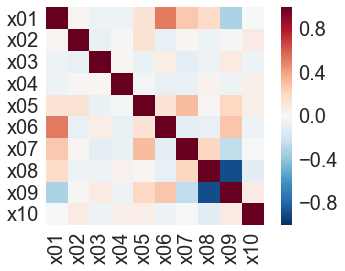

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

sns.heatmap(data.corr(), vmin=-1, vmax=1, square=True);

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variance_inflation_factor?

Iteratively compute the VIF and plot.

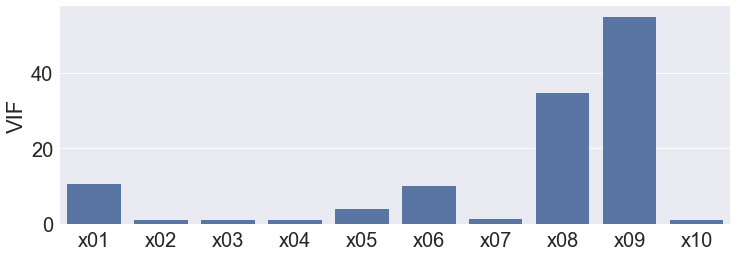

In [7]:
## Compute VIF.
VIF = [variance_inflation_factor(data.as_matrix(), n) for n in range(data.shape[-1])]

## Plot.
fig = plt.figure(figsize=(12,4))
color, = sns.color_palette(n_colors=1)
ax = sns.barplot(np.arange(data.shape[-1]), VIF, color=color);
ax.set(xticklabels=data.columns,  ylabel='VIF');

Drop the collinear variable, recompute VIF, and plot.

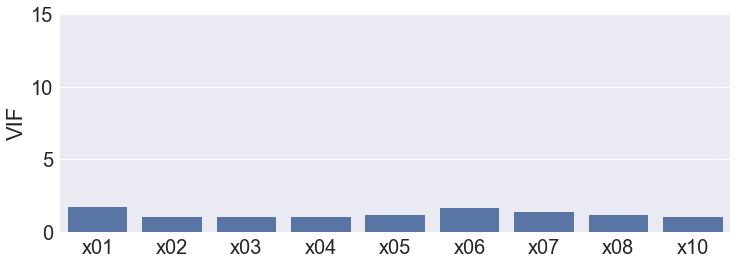

In [8]:
## Drop column x09.
data = data.drop('x09', axis=1)

## Compute VIF.
VIF = [variance_inflation_factor(data.as_matrix(), n) for n in range(data.shape[-1])]

## Plot.
fig = plt.figure(figsize=(12,4))
color, = sns.color_palette(n_colors=1)
ax = sns.barplot(np.arange(data.shape[-1]), VIF, color=color);
ax.set(xticklabels=data.columns, ylim=(0,15), ylabel='VIF');

### Feature Selection
Scikit-Learn also includes a number of features for the automatic reduction of features to those most predictive of an outcome. All feature selection methods can be found under **sklearn.feature_selection**. Preexisting methods include:

|Method|Description|Example|
|------|-----------|-------|
|Univariate| Selection of features with statistically significant relationships to the target. These approaches only consider each feature individually.| SelectKBest, SelectPercentile, SelectFdr, SelectFwe|
|Model-based approaches| Use a supervised machine learning model to judge the importance of features and keep only the most important|SelectFromModel|
|Iterative selection| Build a series of models, either through adding or removing features one-by-one, and stopping when some stopping criterion is reached.| RFE, RFECV |

<br>We will demonstrate feature selection with the simpler univariate approaches, specifically **SelectFwe**, which selects only statistically significant features after controlling for multiple comparisons with family-wise error (FWE) corrections.

In [9]:
from sklearn.feature_selection import SelectPercentile, SelectFdr, SelectFwe

## Initialize feature selection classes.
fwe = SelectFwe(alpha=0.05)

## Fit to data.
fit = fwe.fit(data, data.index)

## Find surviving columns.
fwe_cols = fit.get_support()
fwe_cols

array([ True, False, False, False,  True, False,  True,  True, False], dtype=bool)

Scikit-Learn attributes can be **chained.**

In [10]:
fwe_cols = SelectFwe(alpha=0.05).fit(data,data.index).get_support()
fwe_cols

array([ True, False, False, False,  True, False,  True,  True, False], dtype=bool)

Reduce data to surviving columns.

In [11]:
data = data[data.columns[fwe_cols]]
data.head(5)

,x01,x05,x07,x08
y,,,,
tango,0.053694,0.779390,0.888375,-0.089157
tango,1.045594,-1.254035,-1.212208,1.654749
foxtrot,-0.521661,0.646190,0.237260,-0.021570
foxtrot,-1.367967,-0.135196,0.608270,0.938623
yankee,-1.191913,0.451086,-1.101119,-1.008862


## Unsupervised Learning

In [12]:
from sklearn.decomposition import PCA

## Initialize with desired number of components.
pca = PCA(n_components=2)

## Fit to data.
fit = pca.fit(data)
print(fit.explained_variance_ratio_)

## Transform.
data_2d = fit.transform(data)
print(data_2d.shape)

[ 0.39692612  0.25151459]
(200, 2)


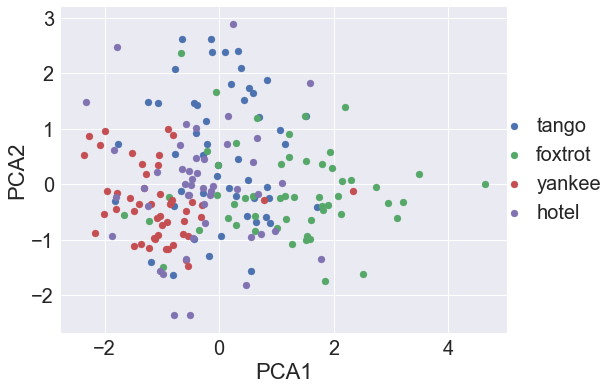

In [13]:
from pandas import DataFrame

## Fit into DataFrame.
data_2d = DataFrame(fit.transform(data), columns=('PCA1','PCA2'), index=data.index)

## Plot.
y_types = data_2d.index.unique()
colors = sns.color_palette(n_colors=len(y_types))

fig, ax = plt.subplots(1,1,figsize=(8,6))
for y, color in zip(y_types, colors):
    ax.scatter(data_2d.loc[y, 'PCA1'], data_2d.loc[y, 'PCA2'], color=color, label=y)
ax.set(xlabel='PCA1', ylabel='PCA2')
ax.legend(loc=7, bbox_to_anchor=(1.25,0.5), handletextpad=0.1);

## Supervised Learning

### Train and Test Sets
Scikit-learn contains a function, **train_test_split**, that shuffles the dataset and splits it for you. This is perhaps the most essential function in all of Scikit-Learn. Fortunately it handles Pandas arrays making it easily compatible with any data that can be read into Python via Pandas. We demonstrate this function below on the diabetes dataset.

In [14]:
from sklearn.model_selection import train_test_split

## Separate out precictors and outcomes.
X = data.as_matrix()
y = data.index

## Split our dataset into four variables using train_test_split.
## We hold out 20% of the data for prediction. All but the last
## column are predictors.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, 
                                                    test_size=0.20, 
                                                    random_state=0)

print('Original data shape: (%s, %s)' %data.shape)
print('Train data shape: (%s, %s)' %X_train.shape)
print('Test data shape: (%s, %s)' %X_test.shape)

Original data shape: (200, 4)
Train data shape: (160, 4)
Test data shape: (40, 4)


### Fitting Models

In [15]:
from sklearn.svm import LinearSVC

## Initialize SVC with desired parameteres.
svc = LinearSVC(penalty='l2', C=1.0, random_state=0)

## Fit to data.
fit = svc.fit(X_train, y_train)

## Compute predictive accuracy to test data.
print('Training performance: %0.3f' %fit.score(X_train, y_train))
print('Test performance: %0.3f' %fit.score(X_test, y_test))

## Show predictions.
predictions = fit.predict(X_test)
predictions

Training performance: 0.762
Test performance: 0.575


array(['tango', 'yankee', 'hotel', 'yankee', 'foxtrot', 'hotel', 'hotel',
       'yankee', 'foxtrot', 'hotel', 'hotel', 'yankee', 'yankee', 'tango',
       'yankee', 'tango', 'yankee', 'foxtrot', 'foxtrot', 'tango',
       'yankee', 'foxtrot', 'yankee', 'yankee', 'foxtrot', 'yankee',
       'tango', 'foxtrot', 'foxtrot', 'yankee', 'yankee', 'hotel',
       'yankee', 'foxtrot', 'hotel', 'foxtrot', 'foxtrot', 'yankee',
       'yankee', 'yankee'], dtype=object)

In [16]:
from sklearn.metrics import confusion_matrix

confmat = DataFrame(confusion_matrix(y_test, predictions), columns=np.unique(y_test), 
                    index=np.unique(y_test))
confmat = confmat.apply(lambda x: x / x.sum(), 1)

confmat.round(3)

,foxtrot,hotel,tango,yankee
foxtrot,0.714,0.000,0.000,0.286
hotel,0.200,0.400,0.200,0.200
tango,0.444,0.222,0.222,0.111
yankee,0.000,0.071,0.071,0.857


### Cross-Validation
One downside to train_test_split is that it splits the data only once. This can be problematic as that one model fit may be unrepresentative of the underlying true model fit as a result of the random allocation of data to the train/test sets. Thus, it is better to test models on multiple sets of the data. Fortunately, Scikit-Learn has many [built-in functions](http://scikit-learn.org/stable/modules/cross_validation.html) for sampling and resampling train/test sets:
* **K-fold:** divides all the samples in k groups of samples, called folds of equal sizes (if possible). The prediction function is learned using k - 1 folds, and the fold left out is used for test.
* **Leave One Out (LOO):** each learning set is created by taking all the samples except one, the test set being the sample left out. This cross-validation procedure does not waste much data as only one sample is removed from the training set.
* **Leave P Out (LPO):** very similar to LeaveOneOut as it creates all the possible training/test sets by removing p samples from the complete set.
* **Shuffle & Split:** generate a user defined number of independent train / test dataset splits. Samples are first shuffled and then split into a pair of train and test sets.
* **Stratified k-fold:** variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.
* **Stratified Shuffle & Split:**  variation of ShuffleSplit, which returns stratified splits, i.e which creates splits by preserving the same percentage for each target class as in the complete set.

We demonstrate two of these functions below.

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
StratifiedShuffleSplit?

In [18]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

for train_ix, test_ix in sss.split(X, y):
    print(train_ix.shape, test_ix.shape)
    
print(train_ix[:10])
print(test_ix[:10])

(160,) (40,)
(160,) (40,)
(160,) (40,)
(160,) (40,)
(160,) (40,)
[199  14 169  47 143 147 188 197 133  57]
[ 77 195 101 158 178  33  51 185  93 131]


#### Visualize the effect of training size on training and test performance

In [19]:
## Define train sizes.
train_sizes = np.linspace(0.2,0.8,13)
n_train_sizes = train_sizes.shape[0]
n_splits = 25
test_size = 0.2

## Preallocate space for performance data.
performance = np.zeros((n_train_sizes,n_splits,3))

## Iteratively compute scores.
for i, train_size in enumerate(train_sizes):
    
    ## Initialize cross-validation tool.
    sss = StratifiedShuffleSplit(n_splits=n_splits, train_size=train_size, 
                                 test_size=test_size, random_state=0)
    
    for j, indices in enumerate(sss.split(X,y)):
        
        ## Extract indices.
        train_ix, test_ix = indices
        
        ## Fit SVC.
        fit = svc.fit(X[train_ix], y[train_ix])
        
        ## Compute performance scores.
        train_score = fit.score(X[train_ix], y[train_ix])
        test_score = fit.score(X[test_ix], y[test_ix])
        
        ## Store information.
        performance[i,j,0] = train_size
        performance[i,j,1] = train_score
        performance[i,j,2] = test_score

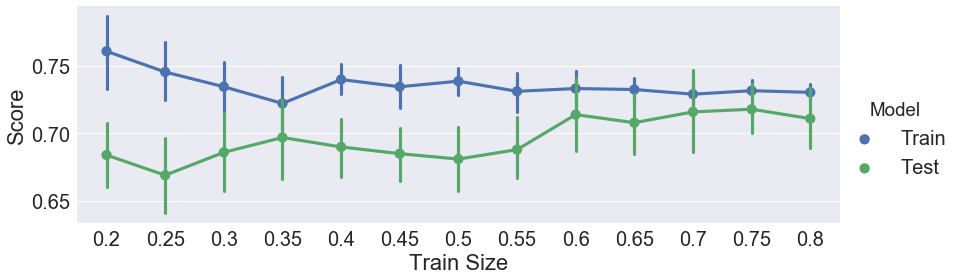

In [20]:
## Convert to DataFrame.
performance = DataFrame(performance.reshape(n_train_sizes*n_splits,3), 
                        columns=('Train Size','Train', 'Test'))

## Melt into longlist.
performance = performance.melt(id_vars='Train Size', var_name='Model', value_name='Score')

## Plot.
sns.factorplot('Train Size', 'Score', 'Model', data=performance, aspect=3);

#### Visualize the effect of sparsity-inducing parameters on model fitting.

In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score?

In [22]:
## Define parameters.
C_params = np.power( 10., [-2, -1, 0, 1, 2] )
n_c_params = C_params.shape[0]
kfold = 10

## Preallocate space for performance data.
performance = np.zeros((n_c_params,kfold,2))

for i, C in enumerate(C_params):
    
    ## Initialize SVC.
    svc = LinearSVC(penalty='l2', C=C, random_state=0)
    
    ## Perform cross-validation.
    scores = cross_val_score(svc, X, y, cv=kfold)
    
    ## Store.
    performance[i,:,0] = C
    performance[i,:,1] = scores

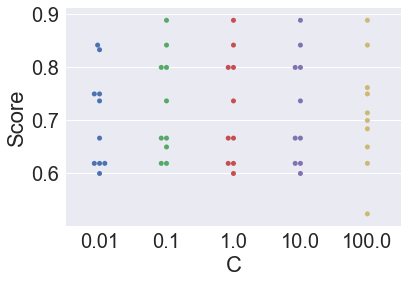

In [23]:
## Convert to DataFrame.
performance = DataFrame(performance.reshape(n_c_params*kfold,2), columns=('C','Score'))

## Plot.
sns.swarmplot('C','Score',data=performance);